In [25]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import boxcox
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from sklearn.model_selection import TimeSeriesSplit
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [2]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [3]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [5]:
dowjones_closing = pd.read_csv("weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("daily-total-female-births-in-cal.csv")

In [6]:
series = dowjones_closing.Close

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


C:\FORPIT2\FFF\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\FORPIT2\FFF\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\FORPIT2\FFF\lib\site-packages\pandas\plotting\_matplotlib\tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\FORPIT2\FFF\lib\site-packages\pandas\plotting\_matplotlib\tools.py:304: MatplotlibDeprecatio

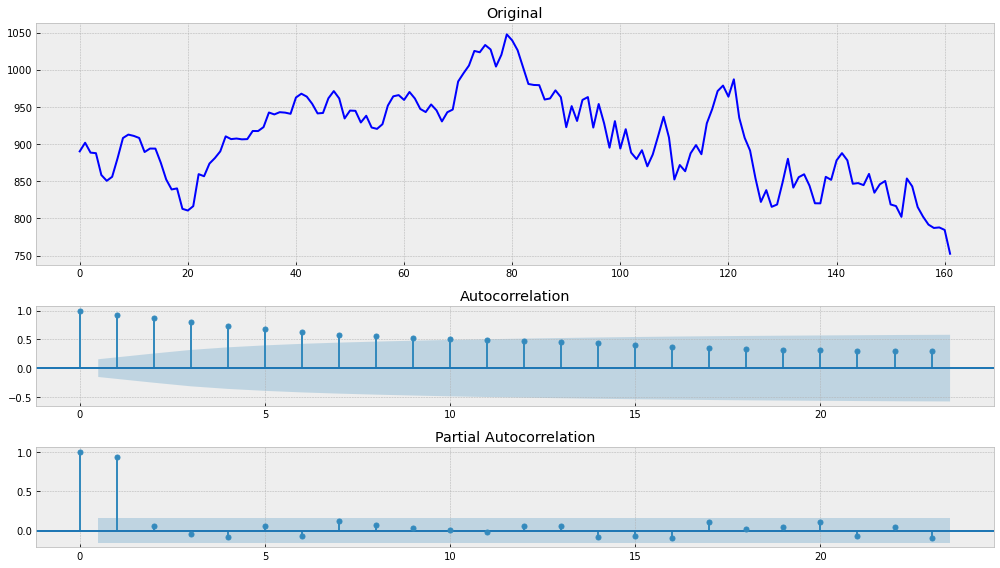

In [7]:
tsplot(series)

В ряде не замечена сезонная компонента, значит можно применить модель без этой компоненты. Попробуем взять двойное экспоненциальное сглаживание

In [9]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [10]:
def plot_dema(series, alpha, beta):
    dema = double_ema(series, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='2', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

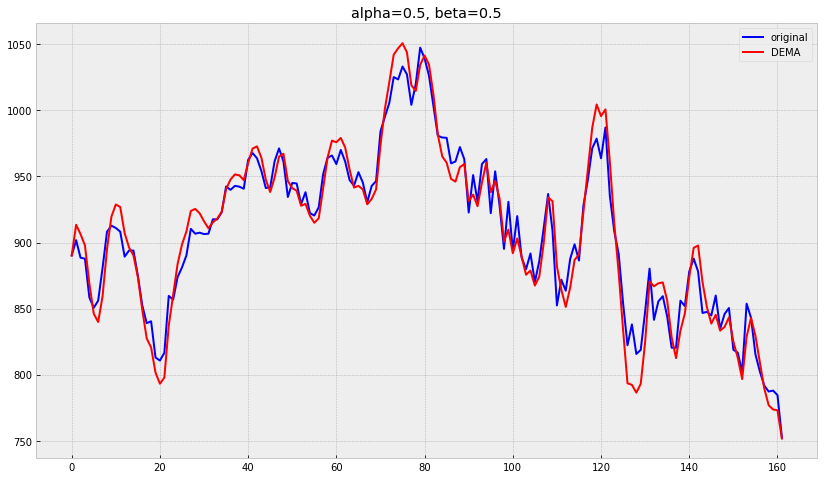

In [11]:
plot_dema(series, 0.5, 0.5)

Подберем параметры модели, в качестве метрики качества возьмем стандартный RMSE:

$RMSE =  \sqrt {1/n \sum^N_{i=1} (\hat{y}_i - y_i)^2}$

In [12]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [13]:
def dema_mse(X):
    alpha, beta = X
    result = double_ema(series, alpha, beta)
    error = mean_squared_error(series, result)
    return error

In [14]:
opt = minimize(dema_mse, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

In [15]:
opt

      fun: 12.421183193288098
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9.76996262e-06, -2.32702746e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 63
      nit: 19
   status: 0
  success: True
        x: array([0.98398901, 0.06019621])

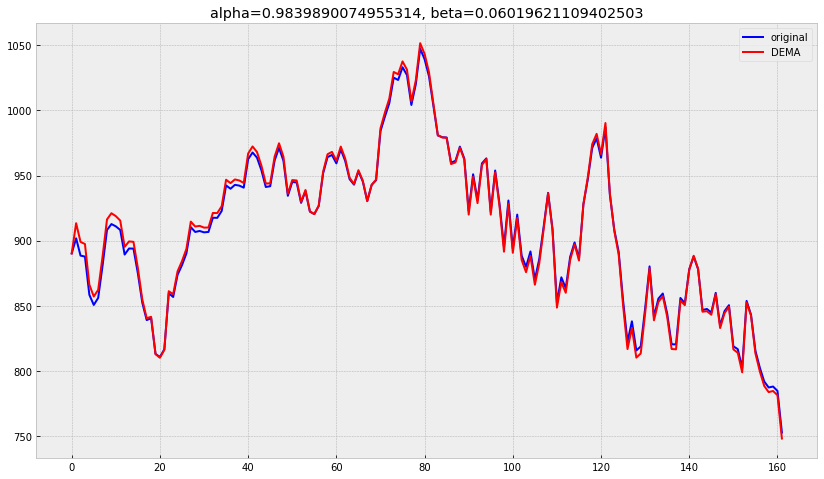

In [16]:
plot_dema(series, opt.x[0], opt.x[1])

In [17]:
print("RMSE:", opt.fun)

RMSE: 12.421183193288098


In [18]:
series = female_births.Count

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


C:\FORPIT2\FFF\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\FORPIT2\FFF\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\FORPIT2\FFF\lib\site-packages\pandas\plotting\_matplotlib\tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\FORPIT2\FFF\lib\site-packages\pandas\plotting\_matplotlib\tools.py:304: MatplotlibDeprecatio

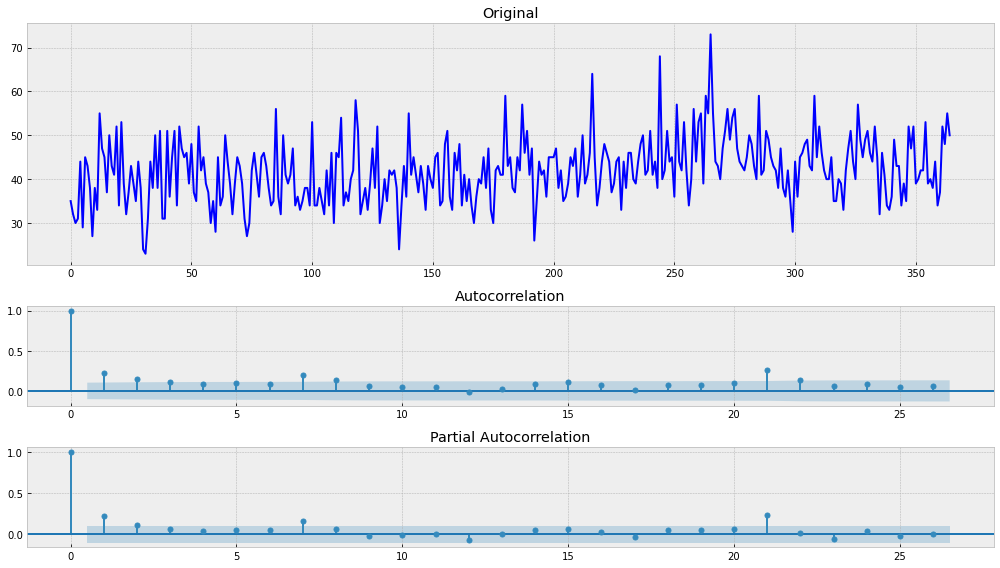

In [19]:
tsplot(series)

Для ряда берем туже модель dema

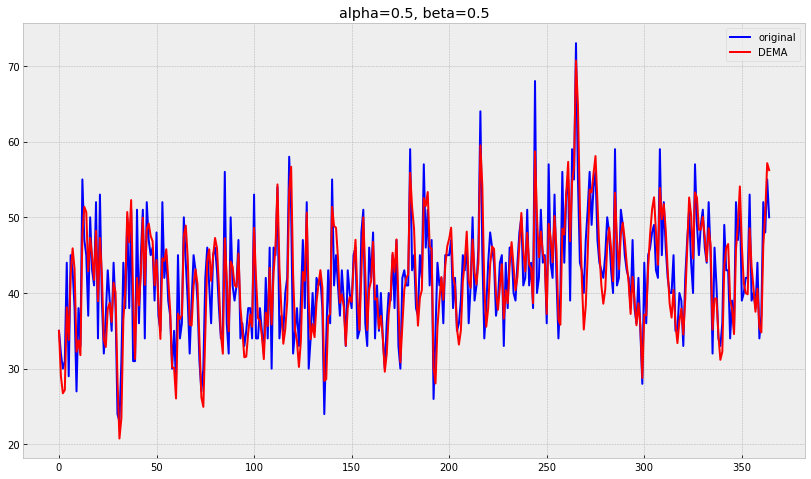

In [20]:
plot_dema(series, 0.5, 0.5)

In [21]:
opt = minimize(dema_mse, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

In [22]:
opt

      fun: 0.26735739534991504
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.75810494e-06, -2.99760217e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 69
      nit: 16
   status: 0
  success: True
        x: array([0.97260973, 0.06039859])

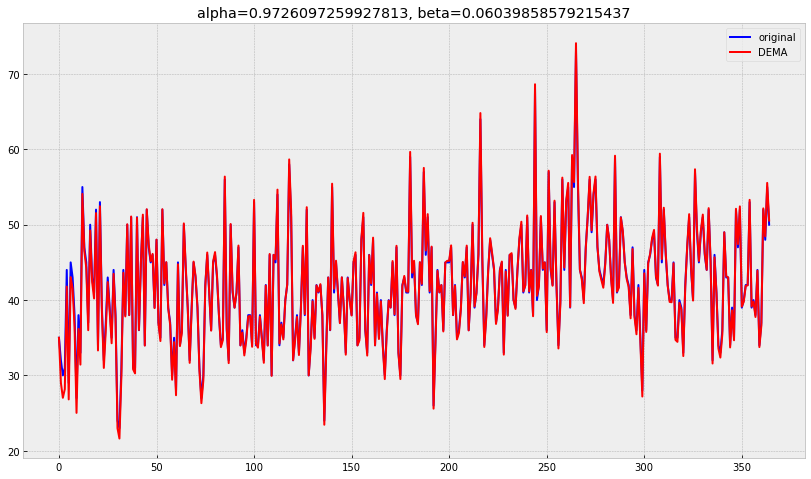

In [23]:
plot_dema(series, opt.x[0], opt.x[1])


In [26]:
print("RMSE:", opt.fun)

RMSE: 0.26735739534991504
